<a href="https://colab.research.google.com/github/KwekuYamoah/Suicide-and-GDP-Case-Study/blob/main/Suicide_and_GDP_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suicide and GDP Case Study

Kweku Andoh Yamoah and Jesse Jackson Zigi

[MIT License]((https://en.wikipedia.org/wiki/MIT_License)

## Introduction
This is the first in a series of notebooks that make up a case study in exploratory data analysis. In this notebook, we

1.   Read data Kaggle. [Suicide Rates Overview 1985 to 2016](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016). The dataset is described as follows:
"*This compiled dataset pulled from four other datasets linked by time and place, and was built to find signals correlated to increased suicide rates among different cohorts globally, across the socio-economic spectrum.*"
2.   Clean the data, particulary dealing with special codes that indicate missing data.
1.   Validate the data by comparing the values in the dataset with values documented in the codebook specified on Kaggle.
2.   Use describe to compute summary statistics and Pmf or Cdf to plot didtribution
1.   Generate "resampled" datasets to ensure efficient randomisation in the dataset
2.   Store the resampled data in a binary format (HDF5) that makes it easier to work with in the notebooks that follow this one.







## The Data

### General Informaation

*   **Original format**: csv
*   **Dataset shape**: 27820 x 12 (rows x columns)
*   19456 missing values for HDI

### Features in the dataset
#### <u>Categorical features</u>
**Country**: A total of 101 countries are included in this dataset. Most countries in Asia are not included and considering we have 195 countries in the world today, this is a quite biased data for worldwide analysis.<br>
**Year**: The dataset goes from 1985 to 2016<br>
**Sex**: Male/female differentiation<br>
**Age**: Age is divided in five age intervals.<br>
**Generation**: There are six generations included in this dataset. See 3.6 for details.
<br>
<blockquote>
    <p><font color="darkblue">This data's level of detail is defined by the combination of <b>Country+Year+Sex+Age</b>, which is a subsample of the population (e.g. Brazillian males of age between 15 and 25 in 1996). <br>For each of those we have corresponding numerical features.</font></p>
</blockquote>

#### <u>Numerical Features</u>
**Population size**: Number of people contained in each subsample
<br>**Number of Suicides**: Number of suicides in each subsample
<br>**Suicides per 100k people**: Number of suicides divided by the population size and multiplied by 100.000. This scales the number for better interpretation and allows you to make comparison between different subsamples.
<br>**GDP for year**: *Gross Domestic Product*, a measure of the market value for a country-year combination.
<br>**GDP per capita**: Obtained by dividing the GDP by the total population of the country for that year.
<br>**HDI for year** : *Human Development Index*, an index that measures life expectancy, income and education.
<br>

### Setup

If you are running this notebook in Colab, the following cell downloads the `empiricaldist` library.

If you are running in another environment, you will need to install it yourself.

In [1]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.3.9-cp36-none-any.whl size=10157 sha256=4127e643fc2752a5e789cfbddc0e17fc7d69377bc23bce500998bcc7704d0b54
  Stored in directory: /root/.cache/pip/wheels/bf/70/8c/55788f5a5806e6da295e5da80d2c0ef286d9a8260a1e3142e1
Successfully built empiricaldist


The following cell loads the packages we need.  If everything works, there should be no error messages. Fingers crossed :)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
from empiricaldist import Pmf

The following cell defines a function I use to decorate the axes in plots.

In [3]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

## Reading the Data
The data we'll use is from Kaggle. I'll keep the original dataset as it is and create a new one to process the data throughout this analysis.

In [4]:
 #Load the data file

import os

if not os.path.exists('master.csv'):
    !wget https://raw.githubusercontent.com/KwekuYamoah/Suicide-and-GDP-Case-Study/main/master.csv


--2020-11-19 15:01:07--  https://raw.githubusercontent.com/KwekuYamoah/Suicide-and-GDP-Case-Study/main/master.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2706377 (2.6M) [text/plain]
Saving to: ‘master.csv’

master.csv          100%[===================>]   2.58M  --.-KB/s    in 0.1s    

2020-11-19 15:01:07 (17.8 MB/s) - ‘master.csv’ saved [2706377/2706377]



Now we can now read the file using Panadas. Pandas will read our information and store the results in a dataframe. We will view a few elements in the dataset to get a sense of the data

In [5]:
original_dataset = pd.read_csv("master.csv")
original_dataset.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


Our data cam in a pretty clear format. Missing values are already recoded with NaN. The next step is to create a copy of the dataset and use it throughout our analysis. We want to maintain the structure of the original dataset. Also, we will rename a few columns to make interpretation and coding easier. Finally we drop some columns which we won't use in our analysis as well.

In [6]:
#Creating a dataset copy
df = original_dataset.copy()

#Renaming a few columns to make interpretation and coding easier
df.rename(columns = {
    'suicides_no':'total_suicides',
    'suicides/100k pop':'suicides_per_100k',
    ' gdp_for_year ($) ':'gdp_for_year',
    'gdp_per_capita ($)':'gdp_per_capita',
    'HDI for year': 'HDI_for_year'
}, inplace=True)

#Dropping country-year
df = df.drop('country-year', axis=1)

#Dropping HDI_for_year due to the number of missing value
#HDI_for_year won't be used in our analysis
df = df.drop(columns='HDI_for_year')


#Values for gdp per year are strings. Fixing to a float
df.gdp_for_year = df.gdp_for_year.apply(lambda x: float(''.join(x.split(','))))

Now let's see how our data set is looking

In [7]:
df = df[df['year']!='2016']
df.head(10)


,country,year,sex,age,total_suicides,population,suicides_per_100k,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,2.156625e+09,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,2.156625e+09,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,2.156625e+09,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,2.156625e+09,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,2.156625e+09,796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,2.156625e+09,796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,2.156625e+09,796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,2.156625e+09,796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,2.156625e+09,796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,2.156625e+09,796,Generation X


## EDA

Years is our time index. We will explore other features together with year to look for trends.
The years range from 1985 to 2016. Let's take a look at both ends of our dataset.

In [8]:
#Creating an aggregate dictionary to get the essential elements of the dataset
agg_dict = {'country':'nunique', 'age':'nunique',
            'population':'sum',
            'total_suicides':'sum',
            'suicides_per_100k':'mean'}
#Query to display  the dataset
dataset = df.query('year >= 1985')

#Grouping by year using the features of agg_dict
dataset = dataset[['year', 'country',
                       'age', 'population',
                       'total_suicides',
                       'suicides_per_100k']].groupby('year').agg(agg_dict)
#Rename columns
'''dataset.rename(columns={'country':'Distinct Countries', 'age':'Age groups',
                          'population':'Sum of Population', 'total_suicides':'Sum of Suicides',
                          'suicides_per_100k':'Avg Suicides Ratio per 100k'}, inplace=True)'''
#Calculating sucide ratio as Sum of Suicides/Sum of Population
dataset['calc_suicide_ratio'] = 1e5 * dataset['total_suicides'] / dataset['population']

dataset

,country,age,population,total_suicides,suicides_per_100k,calc_suicide_ratio
year,,,,,,
1985,48,6,1008600086,116063,11.826198,11.507336
1986,48,6,1029909613,120670,11.423333,11.716562
1987,54,6,1095029726,126842,11.644213,11.583430
1988,49,6,1054094424,121026,12.709405,11.481514
1989,52,6,1225514347,160244,12.879071,13.075653
1990,64,6,1466620100,193361,12.862956,13.184123
1991,64,6,1489988384,198020,13.438880,13.290036
1992,65,6,1569539447,211473,13.498564,13.473570
1993,65,6,1530416654,221565,13.833705,14.477430


*   We can see that the data from 2016 has 16 countires and is missing an age group. We decide no to use this year since it affects our trend analysis.
*   Also the number of countries vary in the data each year.



In [9]:
#Dropping the year "2016"
df = df.query('year !=2016')

Currently we have our cummlative distribution for year, population	total_suicides	suicides_per_100k	calc_suicide_ratio. Now let's look at the mean and standard deviation for total_sucides, suicide_per_100K, calc_suicide_ratio




Calculating this we can use the mean and std functions from numpy and pandas. But we use the one from Pandas

In [10]:
#Mean for total sucides from 1985-2015
mean_tol = dataset['total_suicides'].mean()
std_tol = dataset['total_suicides'].std()
print("Mean and standard deviation of total suicides:\n")
(mean_tol,std_tol)


Mean and standard deviation of total suicides:



(210888.125, 55287.550728864575)

In [11]:
#Doing above suicide_per_100K
mean_100_k = dataset['suicides_per_100k'].mean()
std_100_k = dataset['suicides_per_100k'].std()
print("Mean and standard deviation for suicide per 100K people:\n")
(mean_100_k,std_100_k)

Mean and standard deviation for suicide per 100K people:



(12.816323531728212, 1.3804282716536989)

In [12]:
#Repeating for suicide ratio
mean_ratio= dataset['calc_suicide_ratio'].mean()
std_ratio = dataset['calc_suicide_ratio'].std()
print("Mean and standard deviation for Sucide Ratio by the years:\n")
(mean_ratio,std_ratio)

Mean and standard deviation for Sucide Ratio by the years:



(13.079323991106973, 1.2149916365359779)

Looking at these figures we don't get a sense of what is going on. To solve this we can plot a series of the distrubition over the years

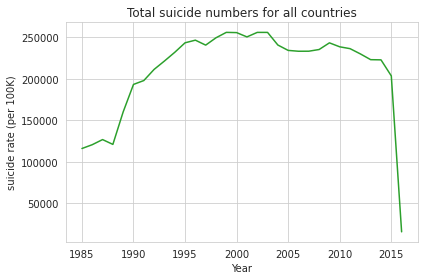

In [13]:
total_suicides = dataset['total_suicides'] 
total_suicides.plot(color="C2", label='Total Suicides')
decorate(xlabel='Year', 
         ylabel='suicide rate (per 100K)',
         title='Total suicide numbers for all countries')



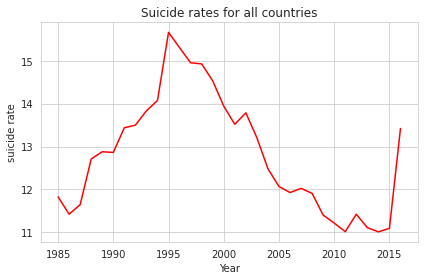

In [14]:
per_100K = dataset['suicides_per_100k'] 
per_100K.plot(color="red", label='Total Suicides')
decorate(xlabel='Year', 
         ylabel='suicide rate',
         title='Suicide rates for all countries')

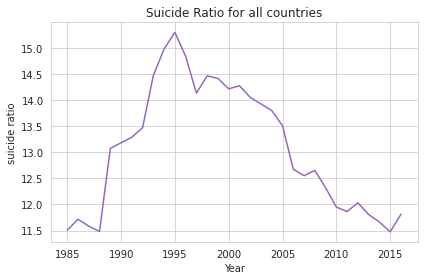

In [15]:
per_100K = dataset['calc_suicide_ratio'] 
per_100K.plot(color="C4", label='Total Suicides')
decorate(xlabel='Year', 
         ylabel='suicide ratio',
         title='Suicide Ratio for all countries')

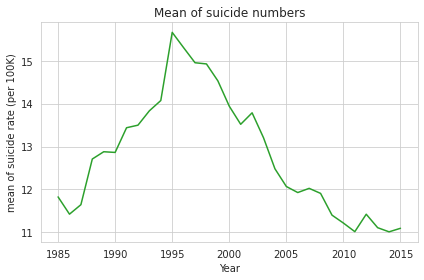

In [16]:
fullDF = df
# Grouping by year
fullDF_by_year = fullDF.groupby('year')
suicide_by_year = fullDF_by_year['suicides_per_100k']
suicide_mean = suicide_by_year.mean()

# Function to decorate plot
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

  
suicide_mean.plot(color='C2', label='suicide numbers')
decorate(xlabel='Year', 
         ylabel='mean of suicide rate (per 100K)',
         title='Mean of suicide numbers')

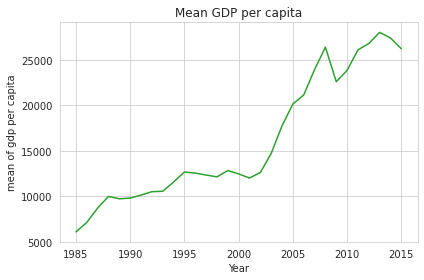

In [17]:
gdp_capita_year = fullDF_by_year['gdp_per_capita']
gdp_capita_mean = gdp_capita_year.mean()
gdp_capita_mean.plot(color='C2', label='GDP per capita')
decorate(xlabel='Year', 
         ylabel='mean of gdp per capita',
         title='Mean GDP per capita')

In [18]:
#cross tabulation of year and gender with mean suicide rate as values
year = fullDF['year']
gender = fullDF['sex']
suicide_rate = fullDF['suicides_per_100k']

yearxgender = pd.crosstab( year, gender, suicide_rate, aggfunc=np.mean)

yearxgender.dropna(inplace=True)
yearxgender.head()


sex,female,male
year,,
1985,5.776910,17.875486
1986,5.812674,17.033993
1987,5.732130,17.556296
1988,6.323401,19.095408
1989,6.176827,19.581314


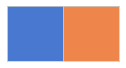

In [19]:
palette = sns.color_palette('muted', 2)
sns.palplot(palette)
columns=['female','male']
color_map = dict(zip(columns, palette))

In [20]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

def plot_columns_lowess(table, columns, colors):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, colors[col])

def anchor_legend(x, y):
    """Place the upper left corner of the legend box.
    
    x: x coordinate
    y: y coordinate
    """
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


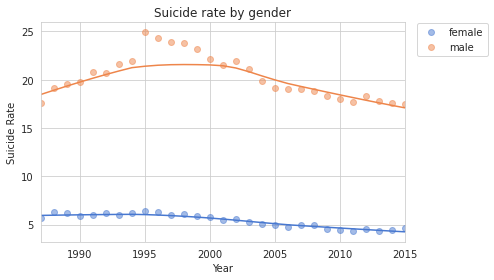

In [21]:
# Male vs Female suicide rate (per 100k)

plot_columns_lowess(yearxgender, columns, color_map)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Suicide rate by gender',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)

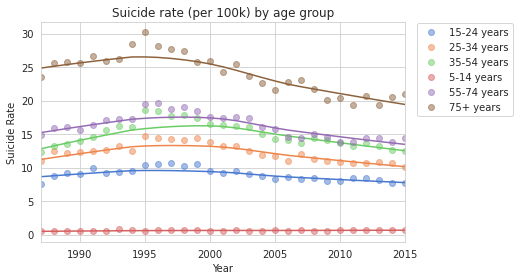

In [22]:
#cross tabulation of year and age with mean suicide rate as values
age = fullDF['age']

yearxage = pd.crosstab( year, age, suicide_rate, aggfunc=np.mean)

yearxage.dropna(inplace=True)
palette1 = sns.color_palette('muted', 6)
columns1=['15-24 years','25-34 years', '35-54 years', '5-14 years', '55-74 years', '75+ years']
color_map2 = dict(zip(columns1, palette1))


# Age group suicide rate (per 100k)

plot_columns_lowess(yearxage, columns1, color_map2)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Suicide rate (per 100k) by age group',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)

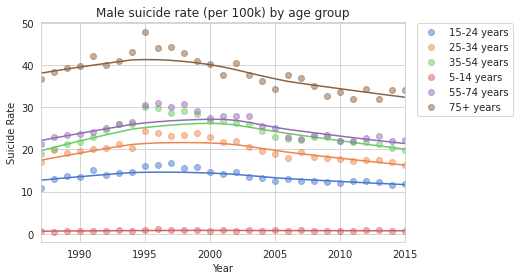

In [23]:
#cross tabulation of year and age by gender (male) with mean suicide rate as values
males = fullDF[fullDF['sex']=='male']

age_male = males['age']

yearxage_male = pd.crosstab( year, age_male, suicide_rate, aggfunc=np.mean)

yearxage_male.dropna(inplace=True)

# Male age groups suicide rate (per 100k)

plot_columns_lowess(yearxage_male, columns1, color_map2)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Male suicide rate (per 100k) by age group',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)

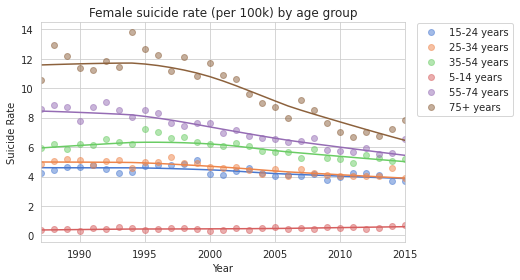

In [24]:
#cross tabulation of year and age by gender (female) with mean suicide rate as values
females = fullDF[fullDF['sex']=='female']

age_female = females['age']

yearxage_female = pd.crosstab( year, age_female, suicide_rate, aggfunc=np.mean)

yearxage_female.dropna(inplace=True)

# Male age groups suicide rate (per 100k)

plot_columns_lowess(yearxage_female, columns1, color_map2)
decorate(xlabel='Year',
         ylabel='Suicide Rate',
         title='Female suicide rate (per 100k) by age group',
         xlim=[1987, 2015])
anchor_legend(1.02, 1.02)